In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle
from statistics import mean, stdev

In [ ]:
#Directory variables

VPREC_IB_DIR = 'vprec_ib'
VPREC_OB_DIR = 'vprec_ob'
IEEE_DIR = 'IEEE'
IEEE_PROTEIN_SCORE_REF = 'ieee_ref.pkl'
THRESHOLD = 0.3

## Calculate protein stats

### VPREC OB

In [27]:
docker_pred = {}
for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        
        docker_pred['%s_%s'%(f1,f2)] = {}
        
        if f1==23 and f2==2: continue
        if f1==7 and f2==2: continue
                
        for i in range(0,646):

            f = open(VPREC_OB_DIR + '/%s_%s_%s.pkl'%(f1,f2,i), 'rb')
            temp = pickle.load(f)
               
            pkl_dict = {}
            for prot in temp:
                pkl_dict[prot] = {}
                for go_id in temp[prot]:
                    if temp[prot][go_id] >= 0.3:
                        pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])

            for protein in pkl_dict.keys():

                docker_pred['%s_%s'%(f1,f2)][protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred['%s_%s'%(f1,f2)][protein][go_id] = np.array([pkl_dict[protein][go_id]])

                    
original_file = open(IEEE_DIR + IEEE_PROTEIN_SCORE_REF, 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]

### VPREC IB

In [5]:
docker_pred = {}
for f1 in [23,7, 2]:
    for f2 in [23,10,7,2]:
        
        docker_pred['%s_%s'%(f1,f2)] = {}
        
        if f1==23 and f2==2: continue
        if f1==7 and f2==2: continue
        if f1==2 and f2==2: continue
                
        for i in range(0,646):

            f = open(VPREC_IB_DIR + '/%s_%s_%s.pkl'%(f1,f2,i), 'rb')
            temp = pickle.load(f)
               
            pkl_dict = {}
            for prot in temp:
                pkl_dict[prot] = {}
                for go_id in temp[prot]:
                    if temp[prot][go_id] >= 0.3:
                        pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])

            for protein in pkl_dict.keys():

                docker_pred['%s_%s'%(f1,f2)][protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred['%s_%s'%(f1,f2)][protein][go_id] = np.array([pkl_dict[protein][go_id]])

                    
original_file = open(IEEE_DIR + IEEE_PROTEIN_SCORE_REF, 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]

In [28]:
missing = {}
same = {}
new = {}

for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        missing['%s_%s'%(f1,f2)] = {}
        same['%s_%s'%(f1,f2)] = {}
        new['%s_%s'%(f1,f2)] = {}
        for prot in docker_pred['%s_%s'%(f1,f2)]:
            
            missing['%s_%s'%(f1,f2)][prot] = []
            same['%s_%s'%(f1,f2)][prot] = []
            new['%s_%s'%(f1,f2)][prot] = []
            
            for go_id in docker_pred['%s_%s'%(f1,f2)][prot]:
                
                if go_id not in original_results[prot].keys(): new['%s_%s'%(f1,f2)][prot].append(go_id)
                else: same['%s_%s'%(f1,f2)][prot].append(go_id)
                    
            for go_id in original_results[prot]:
                if go_id not in docker_pred['%s_%s'%(f1,f2)][prot].keys(): missing['%s_%s'%(f1,f2)][prot].append(go_id)


missing_count = {}
new_count = {}
same_count = {}

for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        missing_count['%s_%s'%(f1,f2)] = 0
        same_count['%s_%s'%(f1,f2)] = 0
        new_count['%s_%s'%(f1,f2)] = 0
        
        for prot in missing['%s_%s'%(f1,f2)]:
            missing_count['%s_%s'%(f1,f2)] += len(missing['%s_%s'%(f1,f2)][prot])
            new_count['%s_%s'%(f1,f2)] += len(new['%s_%s'%(f1,f2)][prot])
            same_count['%s_%s'%(f1,f2)] += len(same['%s_%s'%(f1,f2)][prot])

del same_count['23_2']
del missing_count['23_2']
del new_count['23_2']
del same_count['7_2']
del missing_count['7_2']
del new_count['7_2']

### Metrics

In [29]:
#to avoid duplicate cells point METRICS_DIR to vprec_ob or vprec_ib results
METRICS_DIR = VPREC_OB_DIR

In [30]:
#metric stats
metrics = {}
metric_stats = {}
df_metric = {}

for category in ['bp', 'cc', 'mf']:

    df_metric[category] = {}
    metrics[category] = {}
    metric_stats[category] = {}
        
    for f1 in [23,7,2]:
        for f2 in [23,10,7]:
            if f1 == 2: continue #uncomment for VPREC OB
            
            df_metric[category]['%s_%s'%(f1,f2)] = {}
            metrics[category]['%s_%s'%(f1,f2)] = {'threshold':[], 'Smin':[], 'Fmax':[], 'AUPR':[]}
            metric_stats[category]['%s_%s'%(f1,f2)] = {'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}

            metrics_file = open(METRICS_DIR + "/%s_%s_%s.txt"%(category,f1,f2)) #verrou_formats4
            read_file = csv.reader(metrics_file)

            next(read_file)
            for row in read_file: 
#                 if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0] : continue
                metric, score = row[0].split(': ')
                metrics[category]['%s_%s'%(f1,f2)][metric].append(np.float64(score))

            metrics_file = csv.reader(open(IEEE_DIR + "/%s.txt"%category))
            next(metrics_file)
            for row in metrics_file:
#                 if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0] : continue
                term, score = row[0].split(': ')
                metric_stats[category]['%s_%s'%(f1,f2)][term]['Original Result'] = [np.float64(score)]

            for i in metrics[category]['%s_%s'%(f1,f2)]: 
                    
                metric_stats[category]['%s_%s'%(f1,f2)][i]['VPREC Results'] = metrics[category]['%s_%s'%(f1,f2)][i]
                df_metric[category]['%s_%s'%(f1,f2)]['%s'%i] = pd.DataFrame(metric_stats[category]['%s_%s'%(f1,f2)][i])

# Graphics

### VPREC OB

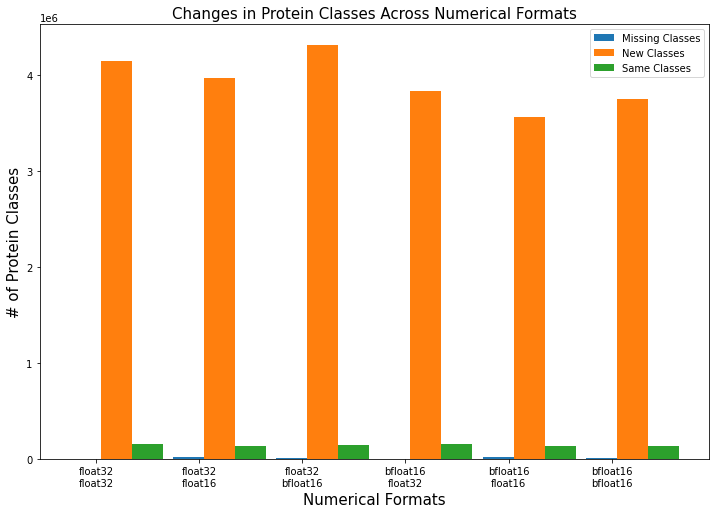

In [31]:
bar_width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
b1 = ax.bar(np.arange(6), list(missing_count.values()), width=bar_width, label='Missing Classes')
b2 = ax.bar(np.arange(6) + bar_width, list(new_count.values()), width=bar_width, label='New Classes')
b3 = ax.bar(np.arange(6) + 2*bar_width, list(same_count.values()), width=bar_width, label='Same Classes')
ax.set_xticks(np.arange(6) + bar_width/3), ax.legend(), ax.set_title('Changes in Protein Classes Across Numerical Formats', fontsize=15)
ax.set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16']);
ax.set_xlabel('Numerical Formats', fontsize=15), ax.set_ylabel('# of Protein Classes', fontsize=15);

### VPREC IB

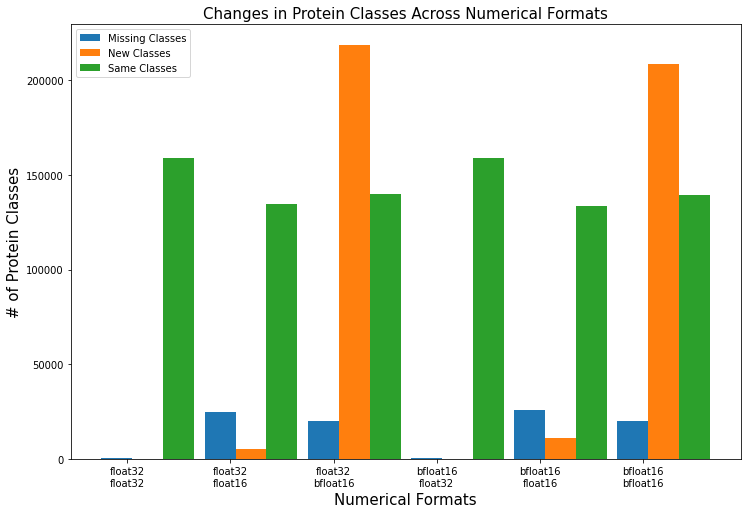

In [8]:
bar_width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
b1 = ax.bar(np.arange(6), list(missing_count.values()), width=bar_width, label='Missing Classes')
b2 = ax.bar(np.arange(6) + bar_width, list(new_count.values()), width=bar_width, label='New Classes')
b3 = ax.bar(np.arange(6) + 2*bar_width, list(same_count.values()), width=bar_width, label='Same Classes')
ax.set_xticks(np.arange(6) + bar_width/3), ax.legend(), ax.set_title('Changes in Protein Classes Across Numerical Formats', fontsize=15)
ax.set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16']);
ax.set_xlabel('Numerical Formats', fontsize=15), ax.set_ylabel('# of Protein Classes', fontsize=15);

## Metrics

### VPREC OB

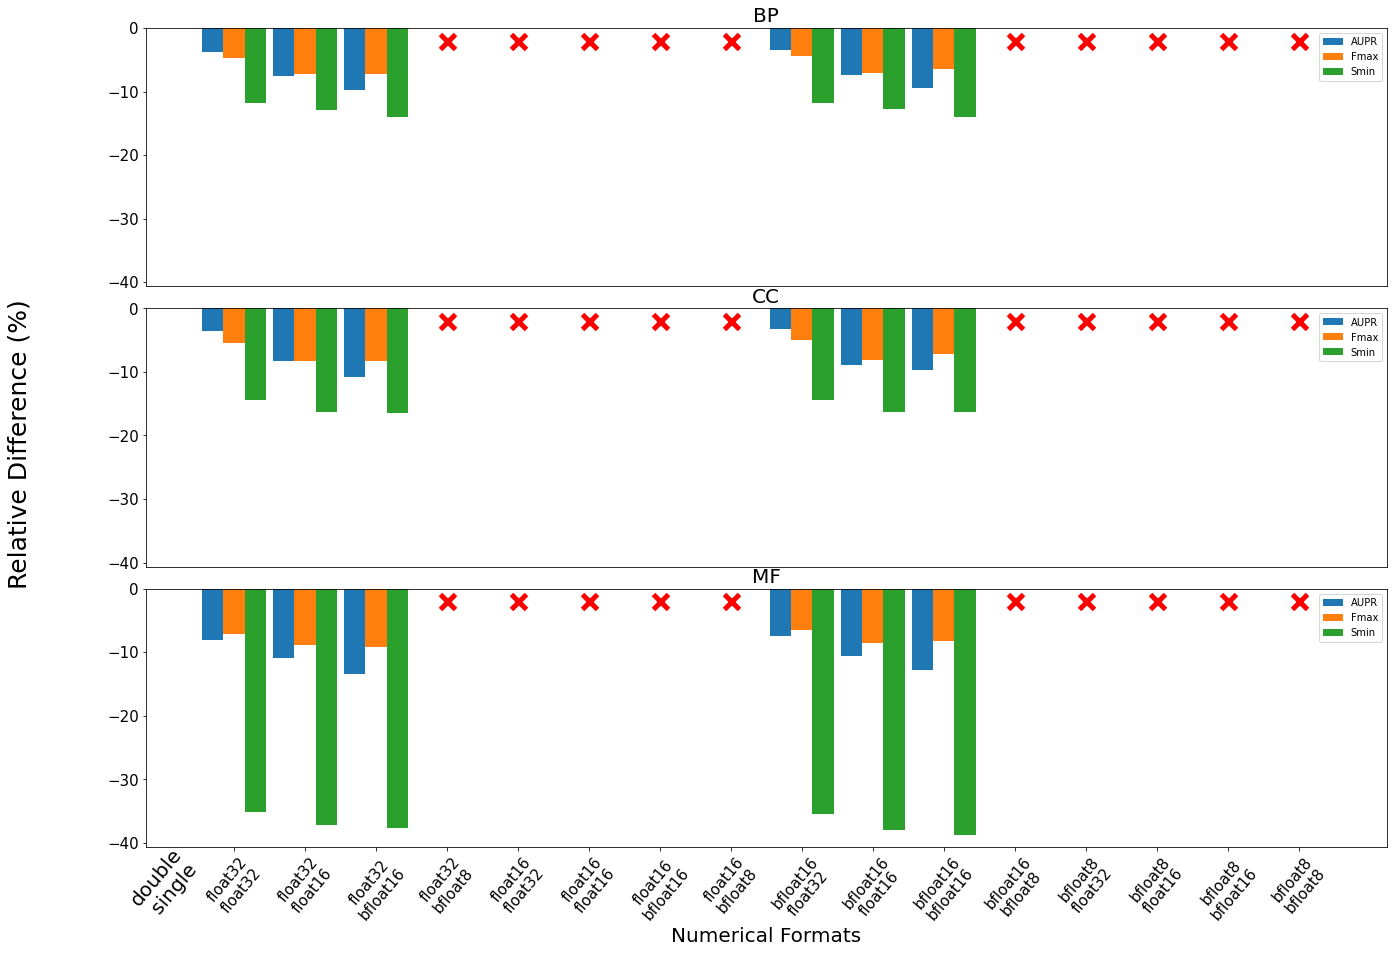

In [33]:
reduced_preds = ['23_23', '23_10', '23_7', '23_2.', '10_23', '10_10', '10_7', '10_2.', '7_23', '7_10', '7_7', '7_2.', '2_23', '2_10', '2_7', '2_2.']
temp = {'aupr':[], 'thresh':[], 'fmax':[], 'smin':[]}
x = np.arange(16)
bar_width = 0.3


fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(18, 12))
gs = fig.add_gridspec(3, hspace=0.0)

fig.tight_layout(pad=1.2)
fig.text(-0.08, 0.5, 'Relative Difference (%)', fontsize=25, va='center', rotation='vertical')

for num, category in enumerate(df_metric):

    
    thresh = []
    smin = []
    fmax = []
    aupr = []

    for format_combo in reduced_preds:
        
        if '10_' in format_combo or '_2.' in format_combo or '2_' in format_combo:
            thresh.append(0)
            smin.append(0)
            fmax.append(0)
            aupr.append(0)
            continue
            
        thresh.append((-(df_metric[category][format_combo]['threshold']['Original Result'] - df_metric[category][format_combo]['threshold']['VPREC Results']).item() / df_metric[category][format_combo]['threshold']['Original Result']).item()*100)
        smin.append(((df_metric[category][format_combo]['Smin']['Original Result'] - df_metric[category][format_combo]['Smin']['VPREC Results']).item() / df_metric[category][format_combo]['Smin']['Original Result']).item()*100)
        fmax.append((-(df_metric[category][format_combo]['Fmax']['Original Result'] - df_metric[category][format_combo]['Fmax']['VPREC Results']).item() / df_metric[category][format_combo]['Fmax']['Original Result']).item()*100)
        aupr.append((-(df_metric[category][format_combo]['AUPR']['Original Result'] - df_metric[category][format_combo]['AUPR']['VPREC Results']).item() / df_metric[category][format_combo]['AUPR']['Original Result']).item()*100)

    b1 = ax[num].bar(x, aupr, width=bar_width, label='AUPR')
    b2 = ax[num].bar(x + bar_width, fmax, width=bar_width, label='Fmax')
    b3 = ax[num].bar(x + 2*bar_width, smin, width=bar_width, label='Smin')
    ax[num].legend(prop={'size': 20})
    ax[num].set_xticks(x + bar_width), ax[num].legend()#, ax.set_title(category + ' Difference between Reduced Precision and IEEE', fontsize=15)
    ax[num].set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'float32\nbfloat8', 'float16\nfloat32', 'float16\nfloat16', 'float16\nbfloat16', 'float16\nbfloat8', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16', 'bfloat16\nbfloat8', 'bfloat8\nfloat32', 'bfloat8\nfloat16', 'bfloat8\nbfloat16', 'bfloat8\nbfloat8'], rotation=50, fontsize=35);
    ax[2].set_xlabel('Numerical Formats', fontsize=20)#, ax[num].set_ylabel('Relative Difference (%)', fontsize=15)
    ax[num].set_title(category.upper(), fontsize=20)
    ax[num].plot(np.arange(16)+0.3, np.ones(16)*-2, 'rx', markevery=[3,4,5,6,7,11,12,13,14,15], mew=5, markersize=15)

    temp['aupr'].append(aupr)
    temp['thresh'].append(thresh)
    temp['fmax'].append(fmax)
    temp['smin'].append(smin)
    
        
for ax in fig.get_axes()[:-1]:
    ax.tick_params(bottom=False, labelbottom=False, labelsize=15)

for ax in fig.get_axes():
    ax.tick_params(labelsize=15)

ax.text(-1.2, -52, 'double\n single', rotation=50, fontsize=20);


plt.savefig('reduced_combo_ob.png', bbox_inches ="tight")

### VPREC IB

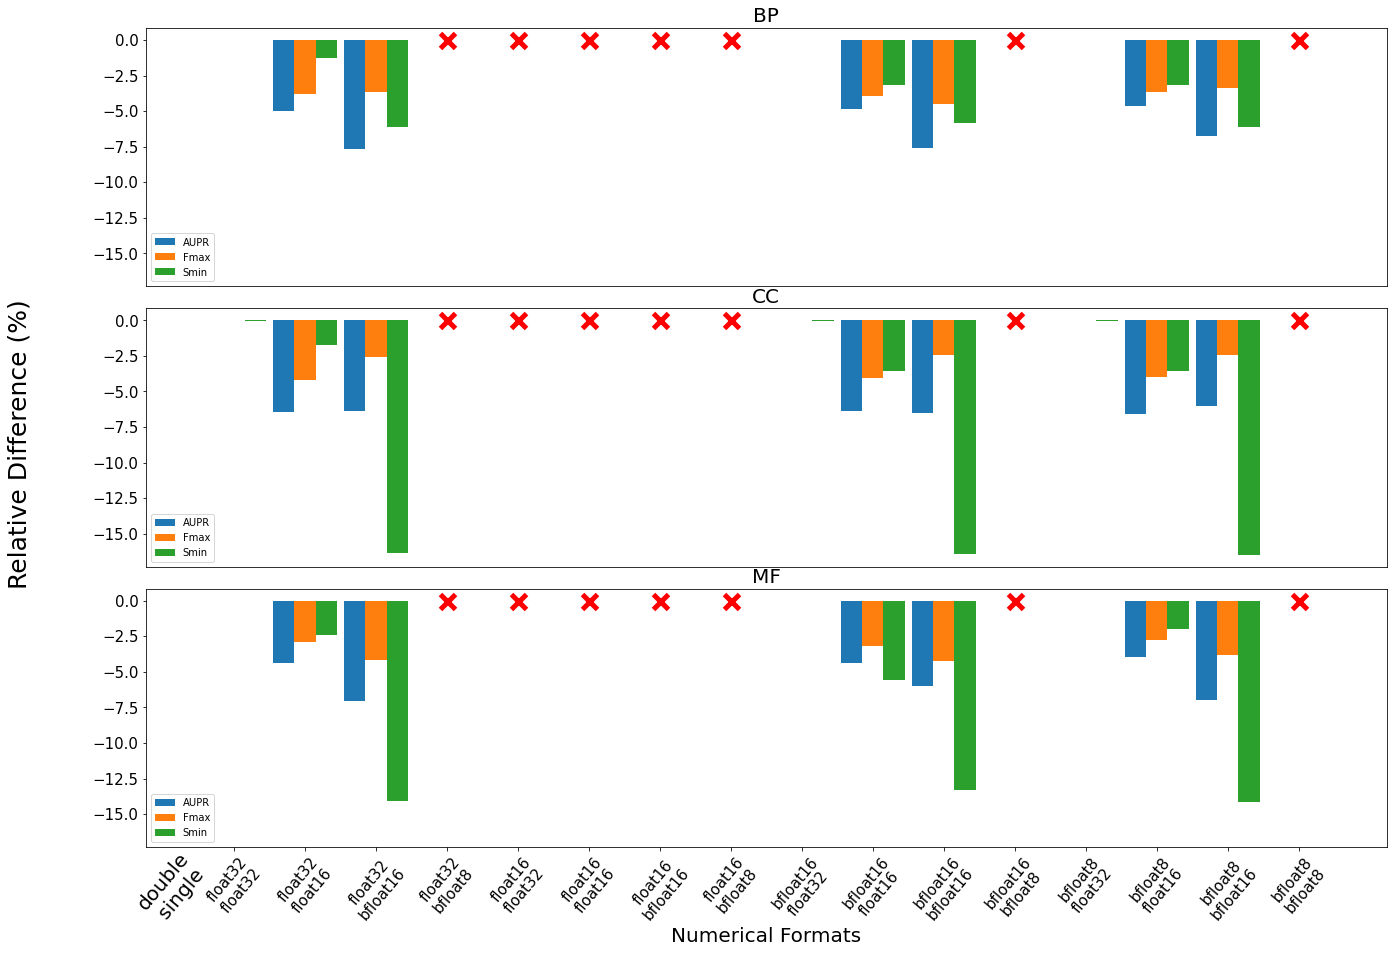

In [23]:
reduced_preds = ['23_23', '23_10', '23_7', '23_2.', '10_23', '10_10', '10_7', '10_2.', '7_23', '7_10', '7_7', '7_2.', '2_23', '2_10', '2_7', '2_2.']
temp = {'aupr':[], 'thresh':[], 'fmax':[], 'smin':[]}
x = np.arange(16)
bar_width = 0.3


fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(18, 12))
gs = fig.add_gridspec(3, hspace=0.0)

fig.tight_layout(pad=1.2)
fig.text(-0.08, 0.5, 'Relative Difference (%)', fontsize=25, va='center', rotation='vertical')

for num, category in enumerate(df_metric):

    
    thresh = []
    smin = []
    fmax = []
    aupr = []

    for format_combo in reduced_preds: 
        
        if '10_' in format_combo or '_2.' in format_combo:
            thresh.append(0)
            smin.append(0)
            fmax.append(0)
            aupr.append(0)
            continue
            
        thresh.append((-(df_metric[category][format_combo]['threshold']['Original Result'] - df_metric[category][format_combo]['threshold']['VPREC Results']).item() / df_metric[category][format_combo]['threshold']['Original Result']).item()*100)
        smin.append(((df_metric[category][format_combo]['Smin']['Original Result'] - df_metric[category][format_combo]['Smin']['VPREC Results']).item() / df_metric[category][format_combo]['Smin']['Original Result']).item()*100)
        fmax.append((-(df_metric[category][format_combo]['Fmax']['Original Result'] - df_metric[category][format_combo]['Fmax']['VPREC Results']).item() / df_metric[category][format_combo]['Fmax']['Original Result']).item()*100)
        aupr.append((-(df_metric[category][format_combo]['AUPR']['Original Result'] - df_metric[category][format_combo]['AUPR']['VPREC Results']).item() / df_metric[category][format_combo]['AUPR']['Original Result']).item()*100)

    
    b1 = ax[num].bar(x, aupr, width=bar_width, label='AUPR')
    b2 = ax[num].bar(x + bar_width, fmax, width=bar_width, label='Fmax')
    b3 = ax[num].bar(x + 2*bar_width, smin, width=bar_width, label='Smin')
    ax[num].legend(prop={'size': 20})
    ax[2].set_xlabel('Numerical Formats', fontsize=20)
    ax[num].set_title(category.upper(), fontsize=20)
        

    ax[num].plot(np.arange(16)+0.3, np.zeros(16), 'rx', markevery=[3,4,5,6,7,11,15], mew=5, markersize=15)
    ax[num].set_xticks(x + bar_width), ax[num].legend()#, ax.set_title(category + ' Difference between Reduced Precision and IEEE', fontsize=15)
    ax[num].set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'float32\nbfloat8', 'float16\nfloat32', 'float16\nfloat16', 'float16\nbfloat16', 'float16\nbfloat8', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16', 'bfloat16\nbfloat8', 'bfloat8\nfloat32', 'bfloat8\nfloat16', 'bfloat8\nbfloat16', 'bfloat8\nbfloat8'], rotation=50, fontsize=35);

    temp['aupr'].append(aupr)
    temp['thresh'].append(thresh)
    temp['fmax'].append(fmax)
    temp['smin'].append(smin)
     

for ax in fig.get_axes()[:-1]:
    ax.tick_params(bottom=False, labelbottom=False, labelsize=15)

for ax in fig.get_axes():
    ax.tick_params(labelsize=15)

ax.text(-1.1, -22.7, 'double\n single', rotation=50, fontsize=20);


plt.savefig('reduced_combo_ib.png', bbox_inches ="tight")